# Reconstruction Search Evaluation
Parse, evaluate and visualize the reconstruction search results

In [69]:
import os
import sys
from pathlib import Path
import json
import copy
import math
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pandas as pd
import seaborn as sns


# Default plot size
plt.rcParams["figure.figsize"] = [30,15]
# sns.set()

In [79]:
def add_thumbnail(ax, file, x, y):
    image = plt.imread(str(file))
    # Check if the RED (0 index) channel is white (1.0)
    bg_mask = image[:,:,0] == 1.0
    # Then set the ALPHA channel to 0
    image[bg_mask, 3] = 0
    offset_image = OffsetImage(image, zoom=0.4)
    ab = AnnotationBbox(offset_image, (x, y), frameon=False)
    ax.add_artist(ab)

def plot_perfect_reconstructions(full_recon_xs, full_recon_ys, labels, title, regraph_limit=None, color=None):
    fig, ax = plt.subplots()
    # Manually set this to the height of the test set
#     ax.set_ylim([0.5, 0.7])
    ax.set_ylim([-0.02, 1.02])
    for index, x in enumerate(full_recon_xs):
        linestyle = "-"
        if labels is not None:
            if labels[index] == "Ground Truth":
                linestyle = "--"
            ax.plot(x, full_recon_ys[index], label=labels[index], color=color[index], linewidth=4, linestyle=linestyle)
        else:
            ax.plot(x, full_recon_ys[index], linewidth=4, color=color[index])
    if regraph_limit is not None:
        ax.axhline(y=regraph_limit, color='dimgray', linestyle='--')
        ax.text(90, regraph_limit - 0.025,'Estimated Representation Upper Limit')

    ax.set_xlabel('Steps')
    ax.set_ylabel('Exact Reconstruction %')
    if title is not None:
        ax.set_title(title)
    if labels is not None:
        ax.legend(loc="lower right", prop={"size":20})
    plt.show()
    
    
def plot_iou_over_time(iou_over_time, labels=None, title=None, color=None):
    fig, ax = plt.subplots()
#     ax.set_ylim([0.7, 0.95])
    ax.set_ylim([-0.02, 1.02])
    for index, iot in enumerate(iou_over_time):
        if labels is not None:
            ax.plot(range(1, len(iot) + 1), iot, label=labels[index], color=color[index], linewidth=4)
        else:
            ax.plot(range(1, len(iot) + 1), iot, linewidth=4, color=color[index])
    ax.set_xlabel('Step')
    ax.set_ylabel('IoU')
    if title is not None:
        ax.set_title(title)
    if labels is not None:
        ax.legend(loc="lower right", prop={"size":20})
    plt.show()

def plot_bargraph(labels, values, title=None, color=None, ylim=None):
    fig, ax = plt.subplots()
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.bar(labels, values, color=color)
    if title is not None:
        ax.set_title(title)
    plt.show()
    
def evaluate_log_file(log_file, budget):
    """Evaluate a single log file"""
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    max_ious = []
    perfect_reconstruction = 0
    best_rollout_attempt = -1
    best_rollout_attempt_index = -1
    current_iou = 0
    used_budget = 0
    
    for index, action in enumerate(log_data):
        # Limit to the budget length
        if action["used_budget"] < budget:
            used_budget = action["used_budget"]
            if action["max_iou"] > current_iou:
                current_iou = action["max_iou"]
                if "rollout_attempt" in action:
                    best_rollout_attempt = action["rollout_attempt"]
                best_rollout_attempt_index = index
            max_ious.append(action["max_iou"])
            if perfect_reconstruction == 0:
                if math.isclose(action["max_iou"], 1, abs_tol=0.00001):
                    perfect_reconstruction = action["used_budget"] + 1

    
    best_rollout_length = 0

    # If we didn't increase the max_iou above 0
    # then we set to the full budge
    if best_rollout_attempt_index < 0:
        best_rollout_length = budget
    # Beam and best search create a prefix which we real the length of directly
    elif "prefix" in log_data[best_rollout_attempt_index]:
        best_rollout_length = len(log_data[best_rollout_attempt_index]["prefix"])
    else:
        max_set = False
        count = False
        max_seen = 0
        best_rollout_length = 1
        # Otherwise loop over again to count the rollout steps taken in the best rollout
        for action in reversed(log_data):
            if action["rollout_attempt"] == best_rollout_attempt:
                if not max_set:
                    # Set the max for this roll out attempt
                    max_seen = action["max_iou"]
                    max_set = True
                # When the max drops below max ever seen, start counting
                if action["max_iou"] < max_seen:
                    count = True
                if count:
                    best_rollout_length += 1
   
    time_taken = log_data[-1]["time"] - log_data[0]["time"]        
    return np.array(max_ious), time_taken, perfect_reconstruction, best_rollout_length, used_budget

def get_design_extrude_count(file):
    """Get the number of extrude steps in a design"""
    with open(file, encoding="utf8") as f:
        json_data = json.load(f)
    timeline = json_data["timeline"]
    entities = json_data["entities"]
    extrude_count = 0
    for timeline_object in timeline:
        entity_uuid = timeline_object["entity"]
        entity_index = timeline_object["index"]
        entity = entities[entity_uuid]
        if entity["type"] == "ExtrudeFeature":
            extrude_count += 1
    return extrude_count

def get_design_extrude_counts(dataset_dir, split_file):
    assert split_file.exists()
    with open(split_file, "r", encoding="utf8") as f:
        split_data = json.load(f)
    counts = []
    for index, test_file in enumerate(split_data["test"]):
        dataset_json_file = dataset_dir / f"{test_file}.json"
        extrude_count = get_design_extrude_count(dataset_json_file)
        counts.append(extrude_count)
    return counts

def get_regraph_limit(results_file, split_file):
    assert results_file.exists()
    with open(results_file, "r", encoding="utf8") as f:
        results_data = json.load(f)
    assert split_file.exists()
    with open(split_file, "r", encoding="utf8") as f:
        split_data = json.load(f)
    result_reasons = []
    for file, results in results_data.items():
        file_stem = Path(file).stem
        if file_stem not in split_data["test"]:
            continue
        if len(results) == 0:
            result_reasons.append("Crash or timeout")
        else:
            result = results[0]
            if result["status"] == "Success":
                result_reasons.append(result["status"])
            else:
                if "reason" in result:
                    result_reasons.append(result["reason"])
                elif "exception" in result:
                    result_reasons.append(result["exception"])
                else:
                    print("Nothing???")

    common = dict(Counter(result_reasons).most_common())
    limit = common["Success"]
#     print("Test Success Count", limit)
    if "Extrude doesn't have start or end faces" in common:
        limit += common["Extrude doesn't have start or end faces"]
    if "Crash or timeout" in common:
        limit += common["Crash or timeout"]
    return limit

def get_budget(log_file):
    """Get the budget from a log file"""
    with open(log_file, "r", encoding="utf8") as f:
        log_data = json.load(f)
    return log_data[0]["budget"]


def set_array_length(array, length):
    if len(array) > length:
        return array[0:length]
    elif len(array) < length:
        last_value = array[-1]
        num_to_add = length - len(array)
        values_to_add = np.full(num_to_add, last_value)
        return np.append(array, values_to_add)
    else:
        return array

def evaluate(log_dir, dataset_dir, split_file):
    """Evaluate an experiments logs"""
    log_files = [f for f in log_dir.glob("**/*_log.json")]
    log_file_map = {}
    for log_file in log_files:
        log_file_map[log_file.stem[:-4]] = log_file
    
    results_file = log_dir / "search_results.json"
    assert results_file.exists()
    with open(results_file, "r", encoding="utf8") as f:
        results_data = json.load(f)
    
    assert split_file.exists()
    with open(split_file, "r", encoding="utf8") as f:
        split_data = json.load(f)
    

    budget = get_budget(log_files[0])
    budgets_used = []
    times_taken = []
    max_iou = []
    max_iou_over_time = np.zeros(shape=(len(split_data["test"]), budget))
    perfect_reconstructions = []
    concise_ratios = []
    max_extrude_count = 0

    result = {
        "log_count": 0,
        "files_processed": 0,
    }
    qual_result = {}
    
    for index, test_file in enumerate(split_data["test"]):
        if test_file in results_data:
            result["files_processed"] += 1
            processing_result = results_data[test_file]
            status = f"files_{processing_result['status'].lower()}"
            if status not in result:
                result[status] = 0
            result[status] += 1
        if test_file not in log_file_map and test_file not in results_data:
            print(f"File does not have a log or processing record! {test_file}")
        
        # Set some default values
        max_ious_raw = np.zeros(budget)
        perfect_reconstruction = 0
        best_rollout_length = 100
        used_budget = 0        
        
        if test_file in log_file_map:
            result["log_count"] += 1     
            log_file = log_file_map[test_file]
            max_ious_raw, time_taken, perfect_reconstruction, best_rollout_length, used_budget = evaluate_log_file(log_file, budget)

       
        dataset_json_file = dataset_dir / f"{test_file}.json"
        extrude_count = get_design_extrude_count(dataset_json_file)
        if extrude_count > max_extrude_count:
            max_extrude_count = extrude_count
        concise_ratio = None
        if perfect_reconstruction > 0:
            concise_ratio =  best_rollout_length / extrude_count
            concise_ratios.append(concise_ratio)
        if test_file in log_file_map:
            times_taken.append(time_taken)
        budgets_used.append(used_budget)
        max_ious = set_array_length(max_ious_raw, budget)
        assert len(max_ious) == budget
        max_iou_max = np.max(max_ious)
        perfect_reconstructions.append(perfect_reconstruction)           
        max_iou.append(max_iou_max)
        max_iou_over_time[index] = max_ious
        
        qual_result[test_file] = {
            "extrude_count": extrude_count,
            "best_rollout_length": best_rollout_length,
            "max_iou": max_iou_max,
            "concise_ratio": concise_ratio,
            "perfect_reconstruction": perfect_reconstruction
        }
       
    result["test_file_count"] = len(split_data["test"])
    result["time_taken_mean"] = np.mean(times_taken)
    result["budget_used_mean"] = np.mean(budgets_used)
    result["conciseness_mean"] = np.exp(np.mean(np.log(concise_ratios)))
    result["perfect_reconstruction"] = np.count_nonzero(perfect_reconstructions)
    result["perfect_reconstructions"] = np.array(perfect_reconstructions)
    result["perfect_reconstruction_percent"] = result["perfect_reconstruction"] / len(split_data["test"])
    result["max_iou_mean"] = np.mean(max_iou)
    result["max_iou_over_time"] = max_iou_over_time
    result["max_extrude_count"] = max_extrude_count
 
    return result, qual_result

## Evaluate the results from each experiment

In [80]:
dataset_dir = Path("/Users/willisk/Autodesk/FusionGallery/Data/Reconstruction/d7/d7")
split_file = dataset_dir.parent / "train_test.json"

In [81]:
# Beam Search
search_label_beam = "Beam"
log_dirs_beam = [
    Path("../log/super_aug_beam_01"), 
    Path("../log/super_beam_07"), 
    Path("../log/super_nogcn_beam_01"),
    Path("../log/rand_beam_01")
]

# Best Search
search_label_best = "Best"
log_dirs_best = [
    Path("../log/super_aug_best_01"), 
    Path("../log/super_best_04"), 
    Path("../log/super_nogcn_best_01"), 
    Path("../log/rand_best_01")    
]

# Random Search
search_label_rand = "Random"
log_dirs_rand = [
    Path("../log/super_aug_rand_01"),
    Path("../log/super_rand_08"),
    Path("../log/super_nogcn_rand_02"),     
    Path("../log/rand_rand_03")
]

agent_labels = [
    "mpn-aug",
    "mpn",   
    "mlp",
    "rand"
]

# Random
search_label = search_label_rand
log_dirs = log_dirs_rand
labels = agent_labels

# Beam
# search_label = search_label_beam
# log_dirs = log_dirs_beam
# labels = agent_labels

colors = sns.color_palette("hls", len(labels))
results = {}
qual_results = {}
for log_dir, label in zip(log_dirs, labels):
    result, qual_result = evaluate(log_dir, dataset_dir, split_file)
    results[label] = result
    qual_results[label] = qual_result

results_df = pd.DataFrame(results)
test_file_count = results_df.loc["test_file_count"][0]
results_df

,mpn-aug,mpn,mlp,rand
log_count,1693,1697,1692,1707
files_processed,1725,1725,1725,1725
files_success,1688,1688,1687,1693
files_fail,17,17,17,17
files_crash,15,15,17,14
files_timeout,5,5,4,1
test_file_count,1725,1725,1725,1725
time_taken_mean,19.609,19.4863,19.0608,4.9603
budget_used_mean,32.3055,33.3739,39.6487,51.0278
conciseness_mean,0.970585,1.0168,0.976339,1.28244


## Plot the reconstruction performance over time

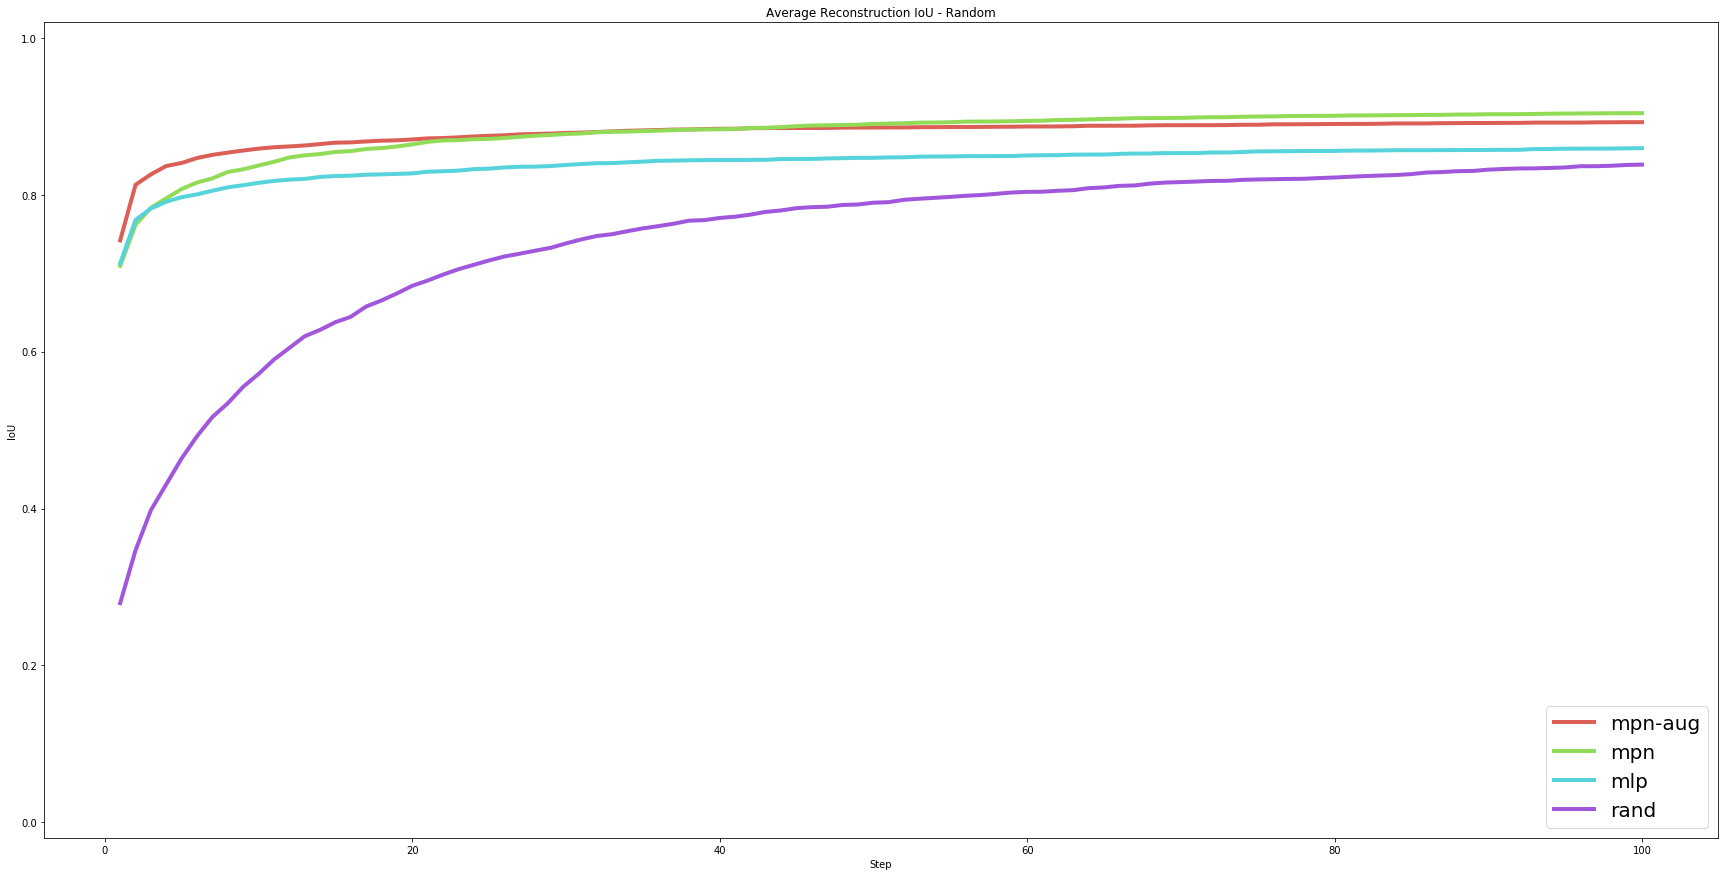

In [82]:
max_iou_mean_over_time = [ np.mean(result, axis=0) for result in results_df.loc["max_iou_over_time"].tolist() ]
plot_iou_over_time(max_iou_mean_over_time, labels, f"Average Reconstruction IoU - {search_label}", color=colors)

## Cumulative Exact Reconstructions

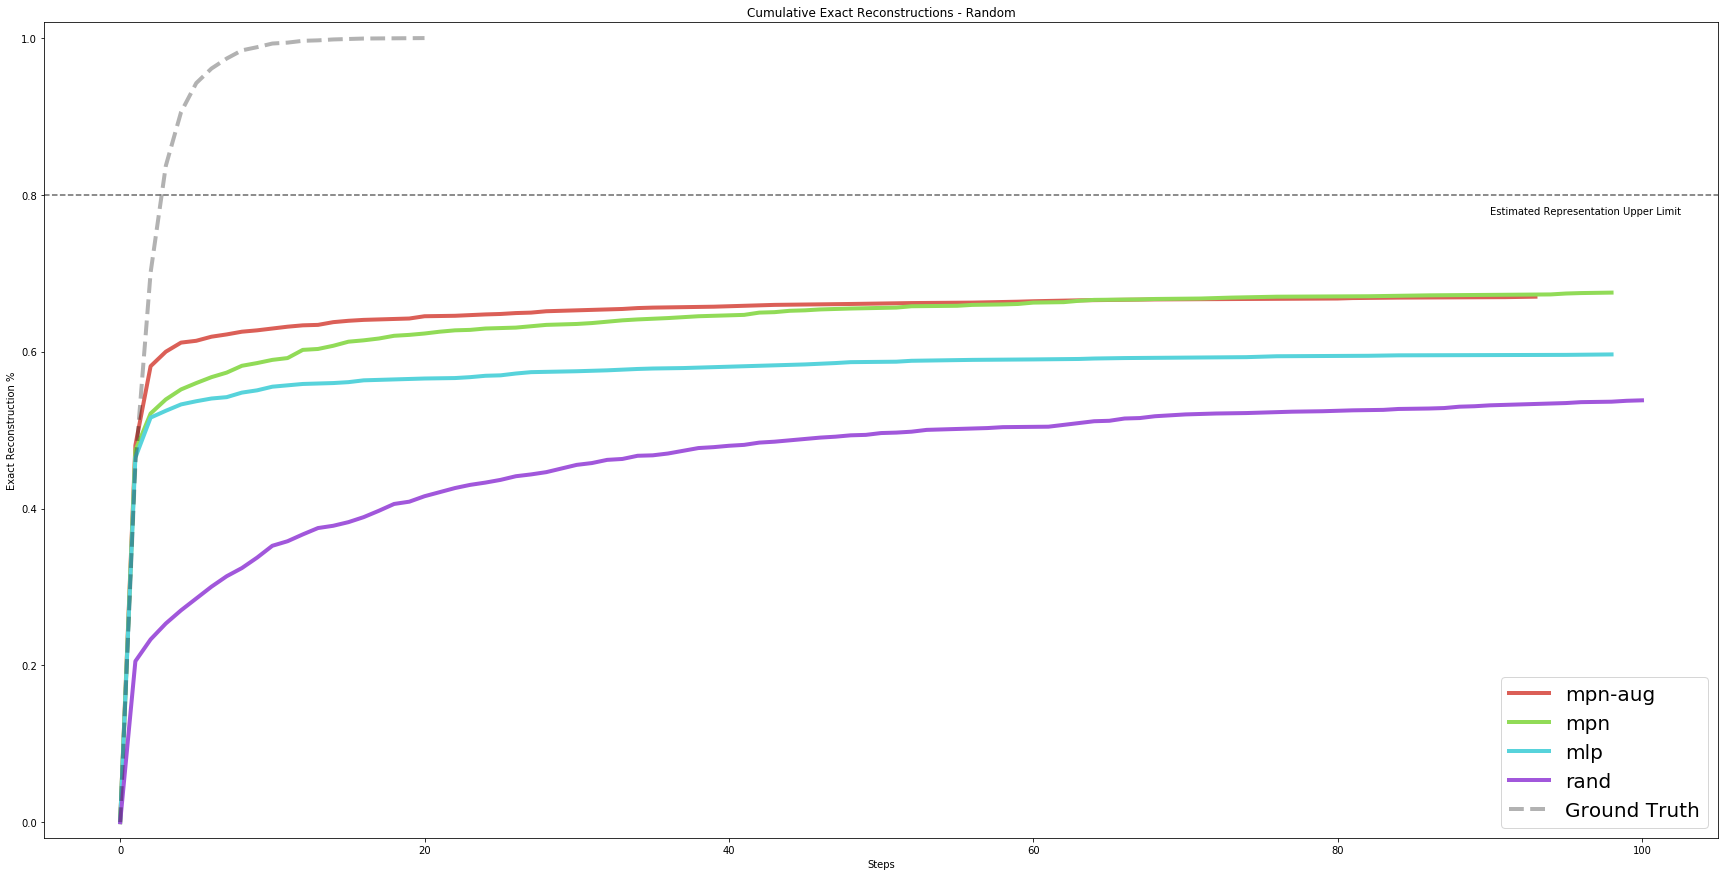

In [83]:
perfect_reconstructions = results_df.loc["perfect_reconstructions"].tolist()

full_recon_ys = [None] * len(perfect_reconstructions)
full_recon_xs = [None] * len(perfect_reconstructions)

for index, perfect_reconstruction in enumerate(perfect_reconstructions):
    (unique, counts) = np.unique(perfect_reconstruction, return_counts=True)
    # Zero out the reconstructions that failed
    counts[0] = 0
    cumsum = np.cumsum(counts) / test_file_count
    full_recon_ys[index] = cumsum
    full_recon_xs[index] = unique

extrude_counts = get_design_extrude_counts(dataset_dir, split_file)
(unique, counts) = np.unique(extrude_counts, return_counts=True)
cumsum = list(np.cumsum(counts) / test_file_count)
unique = list(unique)
cumsum.insert(0, 0)
unique.insert(0, 0)
full_recon_ys.append(cumsum)
full_recon_xs.append(unique)
labels_gt = copy.deepcopy(labels)
labels_gt.append("Ground Truth")
colors_gt = copy.deepcopy(colors)
colors_gt.append([0.0, 0.0, 0.0, 0.3])

# regraph_result_file = Path("../log/regraph/regraph_results_RegraphPerFace_05.json")
# regraph_limit = get_regraph_limit(regraph_result_file, split_file)
# regraph_limit_percent = regraph_limit / test_file_count
regraph_limit_percent = 0.8

plot_perfect_reconstructions(full_recon_xs, full_recon_ys, labels_gt, f"Cumulative Exact Reconstructions - {search_label}", regraph_limit=regraph_limit_percent, color=colors_gt)

## IoU Average

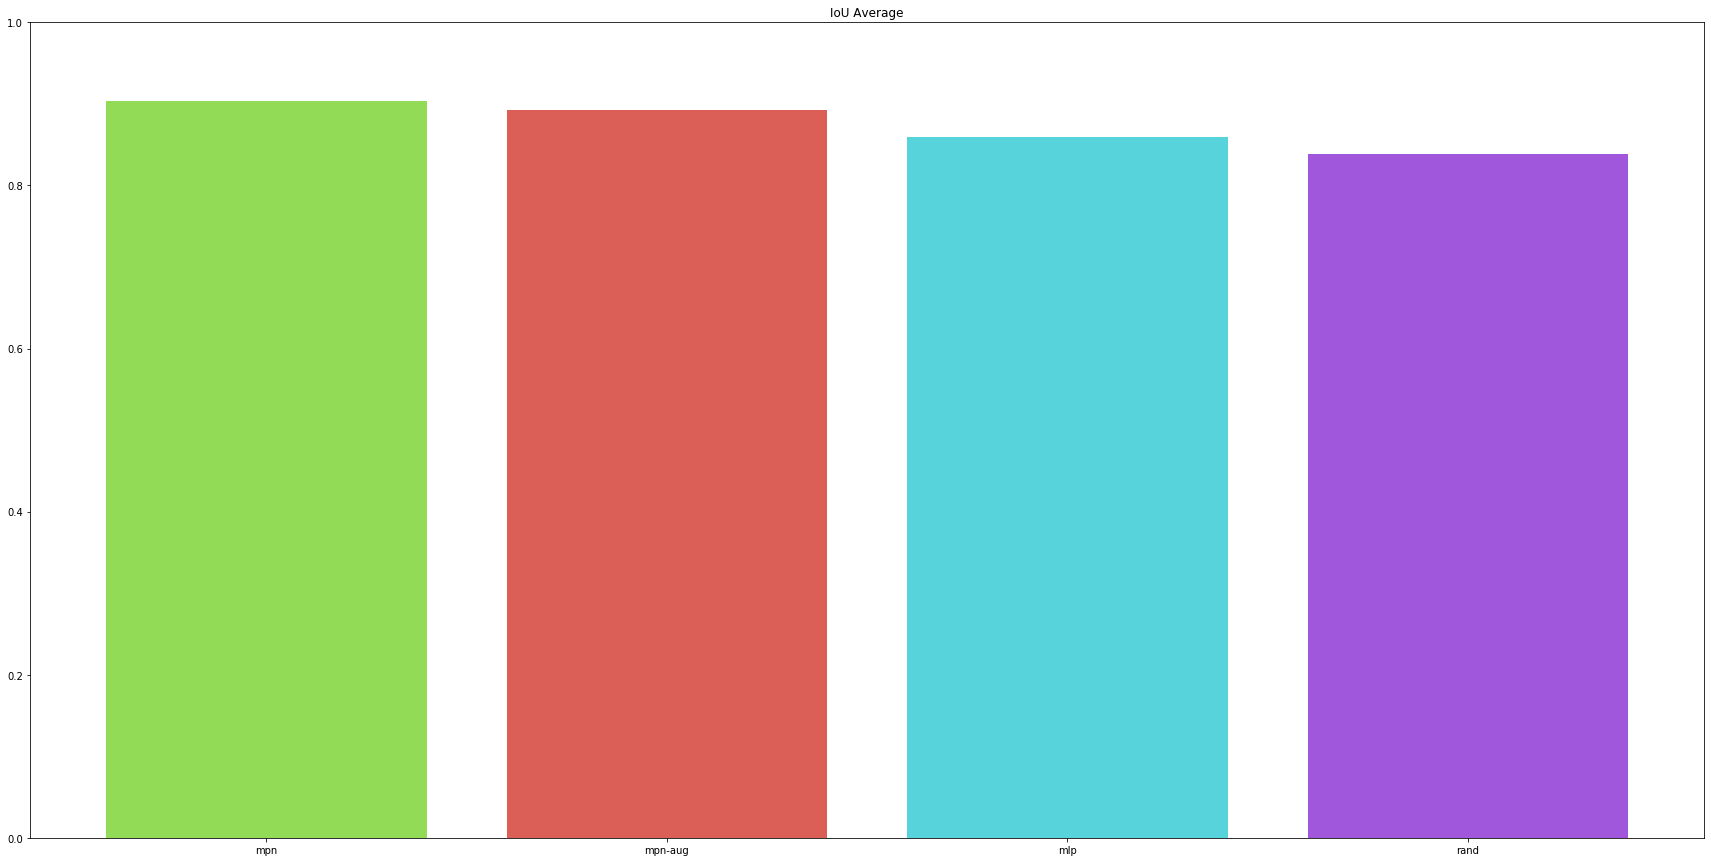

In [84]:
max_iou_mean_100 = []
max_iou_mean_20 = []
for max_iou_result in max_iou_mean_over_time:
    max_iou_mean_100.append(np.max(max_iou_result[:100]))
    max_iou_mean_20.append(np.max(max_iou_result[:20]))

# Plot the results after 100 steps
max_iou_mean = max_iou_mean_100

max_iou_mean_data = zip(max_iou_mean, labels, colors)
max_iou_mean_data_sorted = sorted(max_iou_mean_data, reverse=True)
max_iou_mean_data_unzip = list(zip(*max_iou_mean_data_sorted))

plot_bargraph(max_iou_mean_data_unzip[1], max_iou_mean_data_unzip[0], "IoU Average", color=max_iou_mean_data_unzip[2], ylim=[0,1])

## Conciseness Average

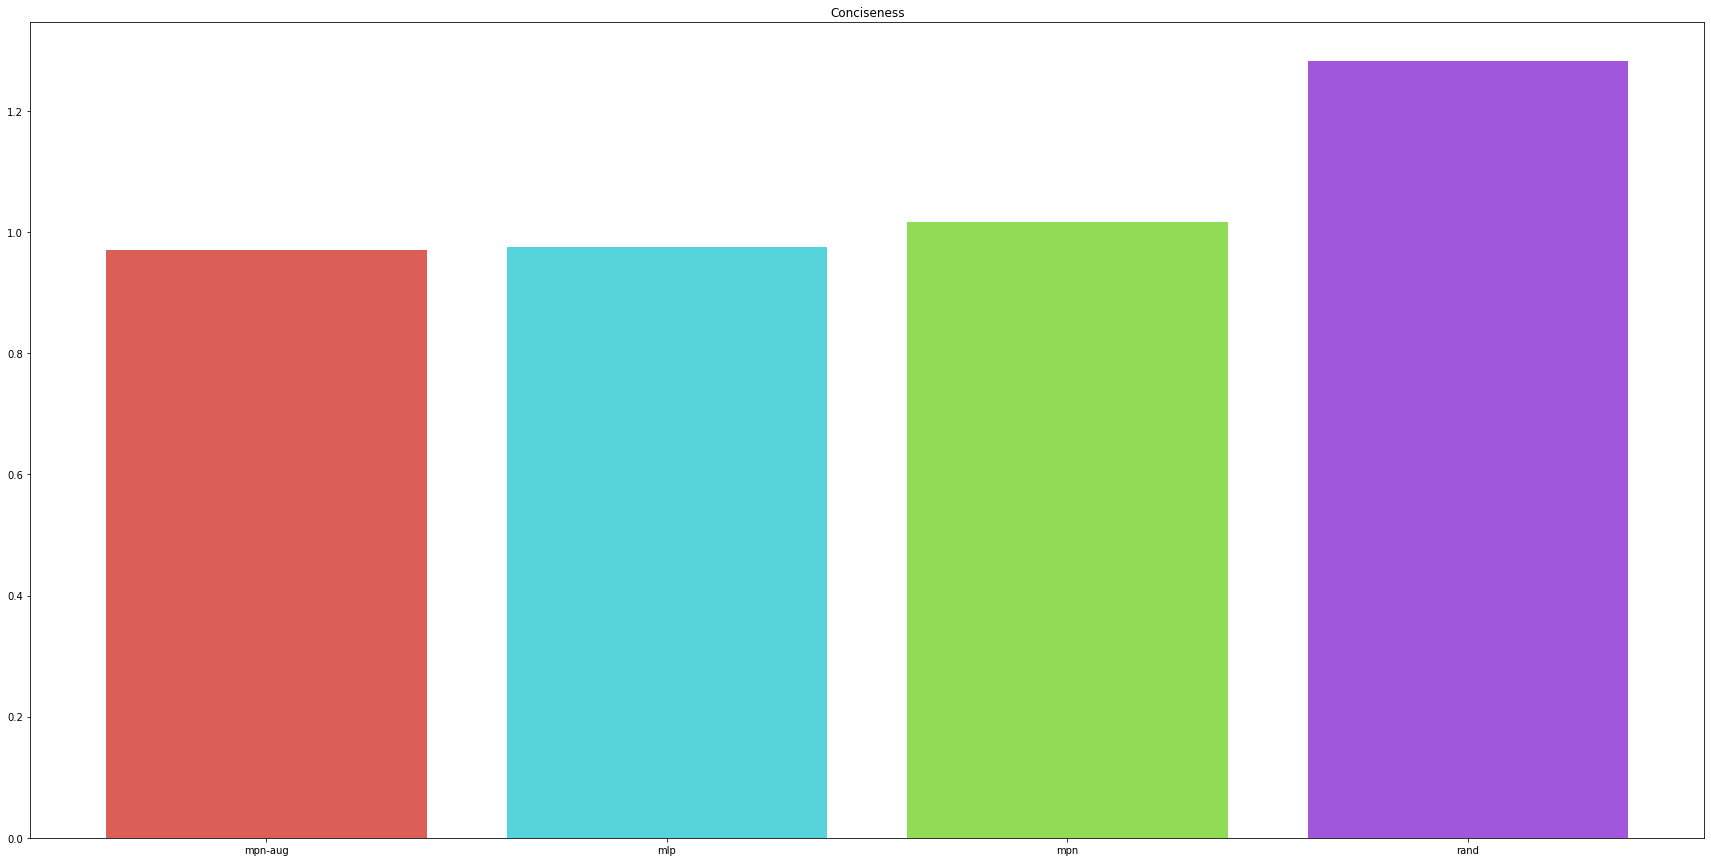

In [85]:
conciseness_mean = results_df.loc["conciseness_mean"].tolist()

conciseness_mean_data = zip(conciseness_mean, labels, colors)
conciseness_mean_data_sorted = sorted(conciseness_mean_data, reverse=False)
conciseness_mean_data_unzip = list(zip(*conciseness_mean_data_sorted))

plot_bargraph(conciseness_mean_data_unzip[1], conciseness_mean_data_unzip[0], "Conciseness", color=conciseness_mean_data_unzip[2])

## Results Table

In [86]:
# Get the number of full reconstructions at 50 and 100 steps
full_recon_20 = []
full_recon_100 = []
for xs, ys in zip(full_recon_xs[:-1], full_recon_ys[:-1]):
    prev_x = 0
    for index, x in enumerate(xs):
        if x == 20:
            result_y = ys[index]
            full_recon_20.append(result_y)
            break
        elif x > 20:
            result_y = ys[prev_index]
            full_recon_20.append(result_y)
            break
        prev_index = index
    full_recon_100.append(ys[-1])        

columns = pd.MultiIndex.from_product([['IoU', 'Exact Reconstruction %'], ['20 Steps', '100 Steps']])
table_results = np.transpose([
    max_iou_mean_20,
    max_iou_mean_100,    
    full_recon_20,
    full_recon_100
])

agents = []
searchs = []
data_aug = []
for label in labels:
    label_parts = label.split(", ")
    if len(label_parts) == 1:
        label_parts[0] == label
        label_parts.append(search_label)
    agent_label = label_parts[0].replace(" Agent", "")
    if "Augmented" in agent_label:
        agent_label = agent_label.replace(" (Augmented)", "")
        data_aug.append("Y")
    else:
        data_aug.append("N")
    agents.append(agent_label)
    searchs.append(label_parts[1].replace(" Search", ""))

df = pd.DataFrame(table_results, columns=columns)
df["Conciseness"] = conciseness_mean
df["Agent"] = agents
# df["Data Aug"] = data_aug
df["Search"] = searchs
cols = df.columns.tolist()
cols_updated = cols[-2:]
cols_updated.extend(cols[:-2])
df = df[cols_updated]
df.round(4).to_clipboard()
df.round(4)

Agent  Search      IoU           Exact Reconstruction %            \
                   20 Steps 100 Steps               20 Steps 100 Steps   
0  mpn-aug  Random   0.8707    0.8928                 0.6452    0.6701   
1      mpn  Random   0.8644    0.9042                 0.6232    0.6754   
2      mlp  Random   0.8274    0.8596                 0.5658    0.5965   
3     rand  Random   0.6840    0.8386                 0.4157    0.5380   

  Conciseness  
               
0      0.9706  
1      1.0168  
2      0.9763  
3      1.2824

In [87]:
def round(x):
    return f"{x:.4f}"

def percent(x):
    return f"{x * 100:.2f}%"

results_table_file = Path("../log/reconstruction_results.tex")
df.to_latex(buf=results_table_file, index=False, formatters=[None, None, round, round, round, round, round], multicolumn=True, column_format="l|rrrrr", multicolumn_format="c")

## Results Figure

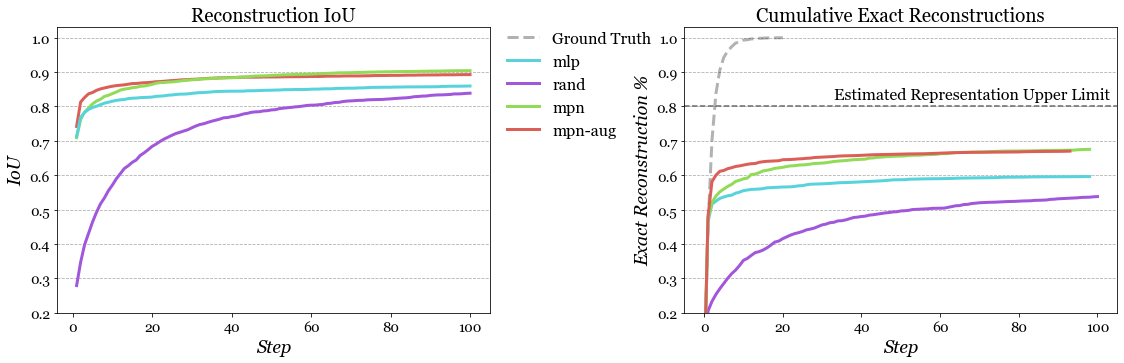

In [88]:
font_family = "Georgia"
title_font = font_manager.FontProperties(family=font_family,
                                   weight='normal',
                                   style='normal', size=19)
legend_font = font_manager.FontProperties(family=font_family,
                                   weight='normal',
                                   style='normal', size=16)
label_font = font_manager.FontProperties(family=font_family,
                                   weight='normal',
                                   style='italic', size=18)
line_width = 3

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(19, 5.25)
# Adjust the space between plots
plt.subplots_adjust(wspace=0.45)

# ax1.set_ylim([-0.05, 1.05])
ax1.set_ylim([0.2, 1.03])
for index, iot in enumerate(max_iou_mean_over_time):
    ax1.plot(range(1, len(iot) + 1), iot, label=labels_gt[index], color=colors[index], linewidth=line_width)
ax1.set_xlabel('Step', fontproperties=label_font)
ax1.set_ylabel('IoU', fontproperties=label_font)
ax1.set_title('Reconstruction IoU', fontproperties=title_font)
for tick in ax1.get_xticklabels():
    tick.set_fontname(font_family)
for tick in ax1.get_yticklabels():
    tick.set_fontname(font_family)
ax1.tick_params(axis='both', labelsize=14)
ax1.yaxis.grid(linestyle='--')

# ax2.set_ylim([-0.05, 1.05])
ax2.set_ylim([0.2, 1.03])
# Custom order for the legend
sort_order = [0, 1, 3, 2, 4]
full_recon_data = zip(full_recon_xs, full_recon_ys, labels_gt, colors_gt, sort_order)
full_recon_data_sorted = sorted(full_recon_data, key = lambda x: x[4], reverse=True)
                                
for xs, ys, label, color, order, in full_recon_data_sorted:
    linestyle = "-"
    if label == "Ground Truth":
        linestyle = "--"
    ax2.plot(xs, ys, label=label, color=color, linewidth=line_width, linestyle=linestyle)
ax2.set_xlabel('Step', fontproperties=label_font)
ax2.set_ylabel('Exact Reconstruction %', fontproperties=label_font)
lgd = plt.legend(loc="lower right", prop=legend_font, frameon=False, bbox_transform=fig.transFigure, bbox_to_anchor=(0.57,0.55), ncol=1)
ax2.set_title("Cumulative Exact Reconstructions", fontproperties=title_font)
for tick in ax2.get_xticklabels():
    tick.set_fontname(font_family)
for tick in ax2.get_yticklabels():
    tick.set_fontname(font_family)
ax2.tick_params(axis='both', labelsize=14)
ax2.yaxis.grid(linestyle='--')
ax2.axhline(y=regraph_limit_percent, color='dimgray', linestyle='--')
ax2.text(33, regraph_limit_percent + 0.02,'Estimated Representation Upper Limit', fontproperties=legend_font)

results_plot_file = Path("../log/reconstruction_results.pdf")
# Save and include the legend
plt.savefig(results_plot_file, bbox_extra_artists=(lgd,), bbox_inches='tight')  
plt.show()
